In [1]:
import pandas

frames = []
for folder in ['samples/udacity/', 'samples/forward/', 'samples/forward2/', 'samples/backward/', 'samples/backward2/', 'samples/recovery/', 'samples/recovery2/', 'samples/recovery3/', 'samples/recovery4/']:
    subdataset = pandas.io.parsers.read_csv(folder + 'driving_log.csv')
    subdataset['left'] = subdataset['left'].apply(lambda x: folder + str.strip(x))
    subdataset['center'] = subdataset['center'].apply(lambda x: folder + str.strip(x))
    subdataset['right'] = subdataset['right'].apply(lambda x: folder + str.strip(x))

    frames.append(subdataset)

dataset = pandas.concat(frames)
dataset = dataset.reset_index(drop=True)
print(len(dataset))

24582


In [2]:
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

Distribution samples by steering


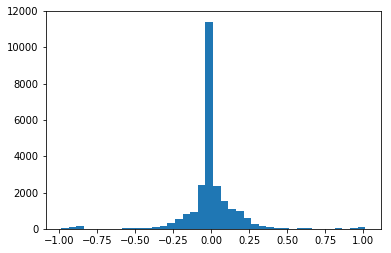

In [3]:
steering = dataset['steering']
binwidth = 0.05

print("Distribution samples by steering")
plt.hist(steering, bins=np.arange(min(steering), max(steering) + binwidth, binwidth))
plt.show()

Distribution samples by steering


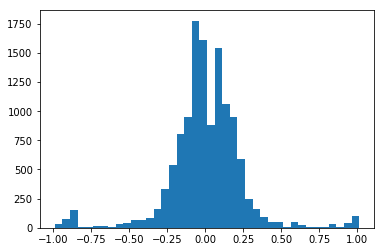

12670
11912
24582
Distribution samples by steering


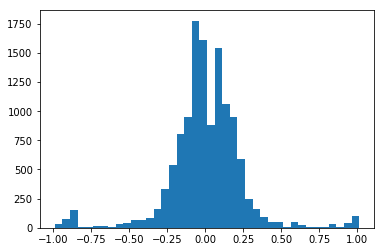

12670

In [10]:
import math

cnt = 0;
eps = 0.05
new_steering = []

for angle in steering:
    if abs(angle) <= eps:
        if cnt < 1:
            new_steering.append(angle)
            cnt+=1
        elif cnt > 7:
            cnt = 0
        else:
            cnt+=1
    else:
        new_steering.append(angle)
        cnt = 0
        
binwidth = 0.05

print("Distribution samples by steering")
plt.hist(new_steering, bins=np.arange(min(new_steering), max(new_steering) + binwidth, binwidth))
plt.show()

cnt = 0
print(len(new_steering))

indexes = []
for index, row in dataset.iterrows():
    angle = row['steering']
    if abs(angle) <= eps:
        if cnt < 1:
            cnt+=1
        elif cnt > 7:
            cnt = 0
            indexes.append(index)
        else:
            cnt+=1
            indexes.append(index)
    else:
        cnt = 0
    
print(len(indexes))    
print(len(dataset['steering']))
dataset1 = dataset.drop(dataset.index[indexes], axis=0)

steering1 = dataset1['steering']
binwidth = 0.05

print("Distribution samples by steering")
plt.hist(steering1, bins=np.arange(min(steering1), max(steering1) + binwidth, binwidth))
plt.show()
len(steering1)

In [12]:
dataset1 = dataset1.reset_index(drop=True)

                                              center  \
2  samples/udacity/IMG/center_2016_12_01_13_31_14...   

                                                left  \
2  samples/udacity/IMG/left_2016_12_01_13_31_14_6...   

                                               right  steering  throttle  \
2  samples/udacity/IMG/right_2016_12_01_13_31_14_...       0.0       0.0   

   brake     speed  
2    0.0  1.230361  


In [88]:
np.random.seed(17)
idxs = np.random.choice(len(dataset1), 5)
pathes = []
steering = []
for idx in idxs:
    pathes.append(dataset1.get_value(idx, 'left'))# .loc[[idx]]['left'])
    pathes.append(dataset1.get_value(idx, 'center'))
    pathes.append(dataset1.get_value(idx, 'right'))
    steering.append(dataset1.get_value(idx, 'steering') - 0.25)
    steering.append(dataset1.get_value(idx, 'steering'))
    steering.append(dataset1.get_value(idx, 'steering') + 0.25)

In [89]:
import cv2

def load_image(name):
    image = cv2.imread(name)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    return image

In [90]:
images = []
for p in pathes:
    images.append(load_image(p))

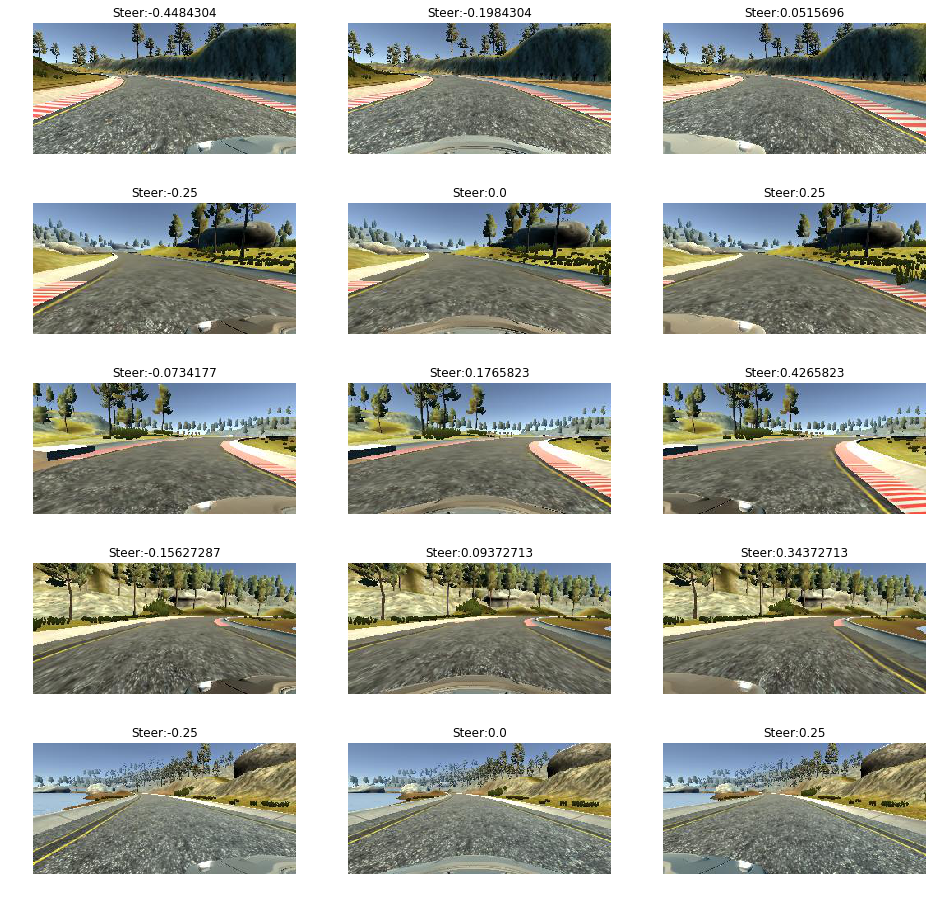

In [91]:
plt.figure(figsize=(16,16))
for i in range(len(images)):
    plt.subplot(5,3,i+1)
    plt.title('Steer:'+ str(steering[i]))
    plt.imshow(images[i])
    plt.axis('off')

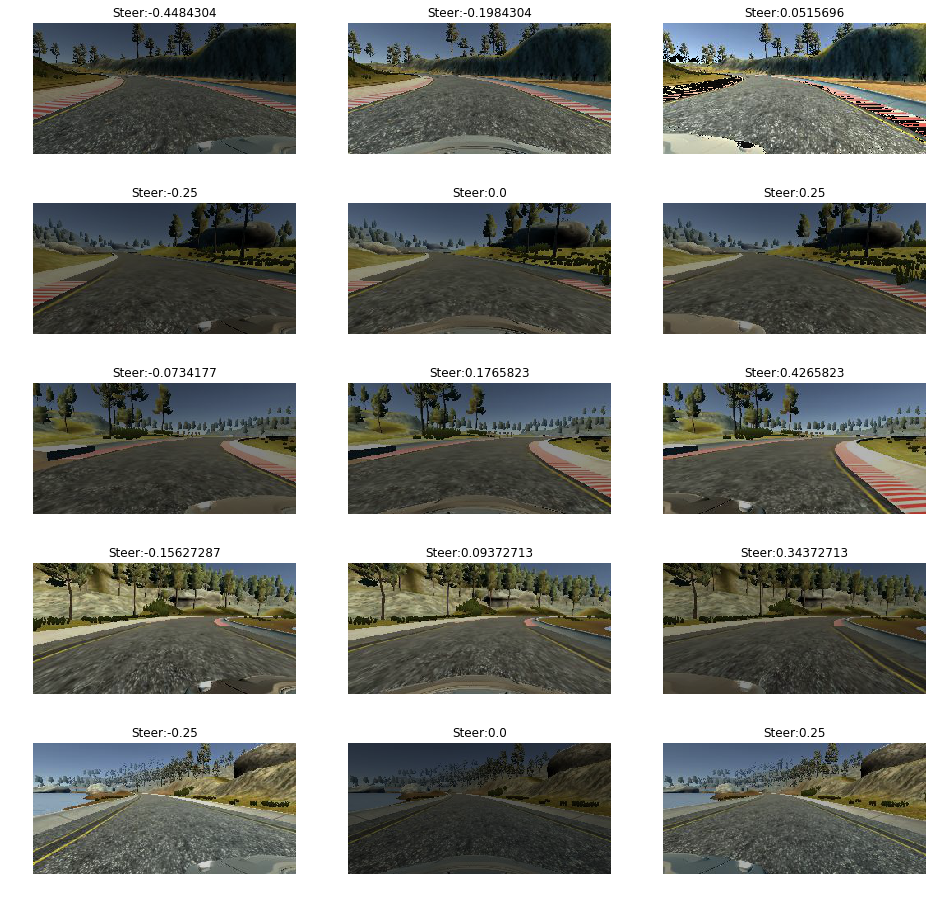

In [92]:
import random

def augment_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = 1.0 + random.uniform(-0.7, 0.3)
    image1[:,:,2] = image1[:,:,2]*random_bright
   
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

plt.figure(figsize=(16,16))
for i in range(len(images)):
    plt.subplot(5,3,i+1)
    plt.title('Steer:'+ str(steering[i]))
    plt.imshow(augment_brightness(images[i]))
    plt.axis('off')

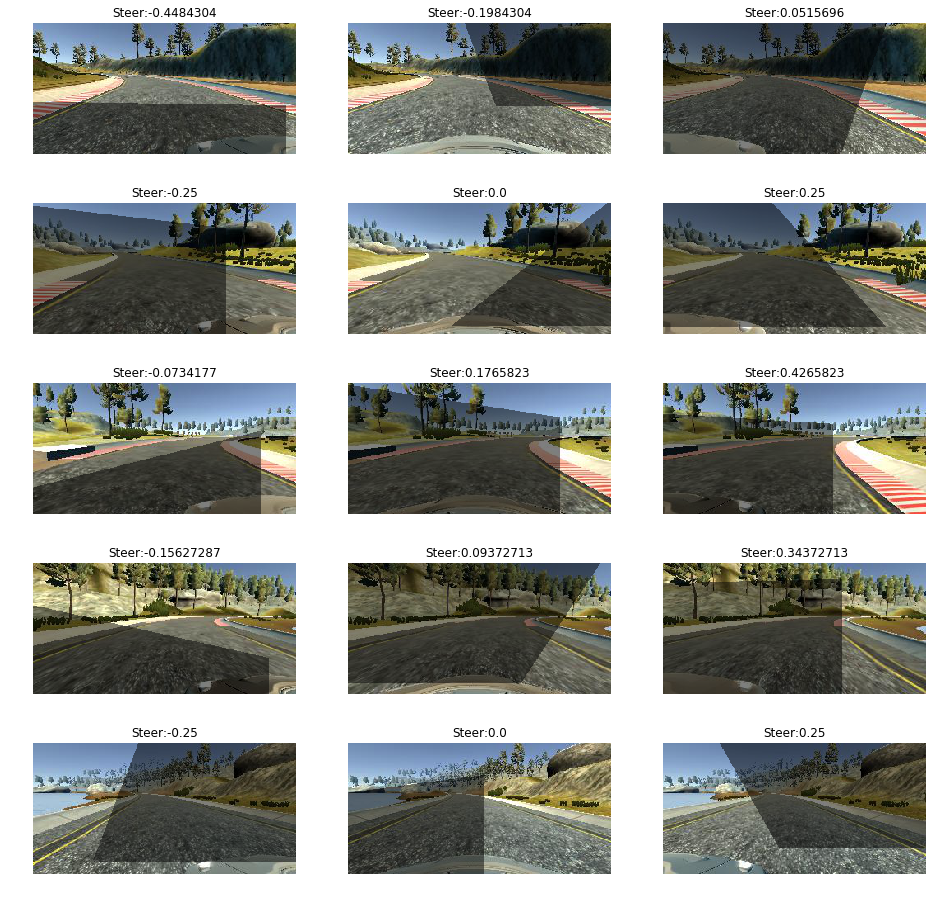

In [100]:
def simple_shadow(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    if bool(random.getrandbits(1)):
        h, w = image1.shape[0], image1.shape[1]
        [x1, x2] = np.random.choice(w, 2, replace=False)
        k = h / (x2 - x1)
        b = -k * x1
        if bool(random.getrandbits(1)):
            for i in range(random.randint(int(h/2.), h)):
                c = int((i - b) / k)
                image1[i, :c, 2] = image1[i, :c, 2] * .5
        else: 
            for i in range(random.randint(int(h/2.), h)):
                c = int((i - b) / k)
                image1[i, c:, 2] = image1[i, c:, 2] * .5
    else:
        h, w = image1.shape[0], image1.shape[1]
        [y1, y2] = np.random.choice(h, 2, replace=False)
        k = w / (y2 - y1)
        b = -k * y1
        if bool(random.getrandbits(1)):
            for i in range(random.randint(int(w/2.), w)):
                c = int((i - b) / k)
                image1[:c, i, 2] = image1[:c, i, 2] * .5
        else: 
            for i in range(random.randint(int(w/2.), w)):
                c = int((i - b) / k)
                image1[c:, i, 2] = image1[c:, i, 2] * .5
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1
                
plt.figure(figsize=(16,16))
for i in range(len(images)):
    plt.subplot(5,3,i+1)
    plt.title('Steer:'+ str(steering[i]))
    plt.imshow(simple_shadow(images[i]))
    plt.axis('off')

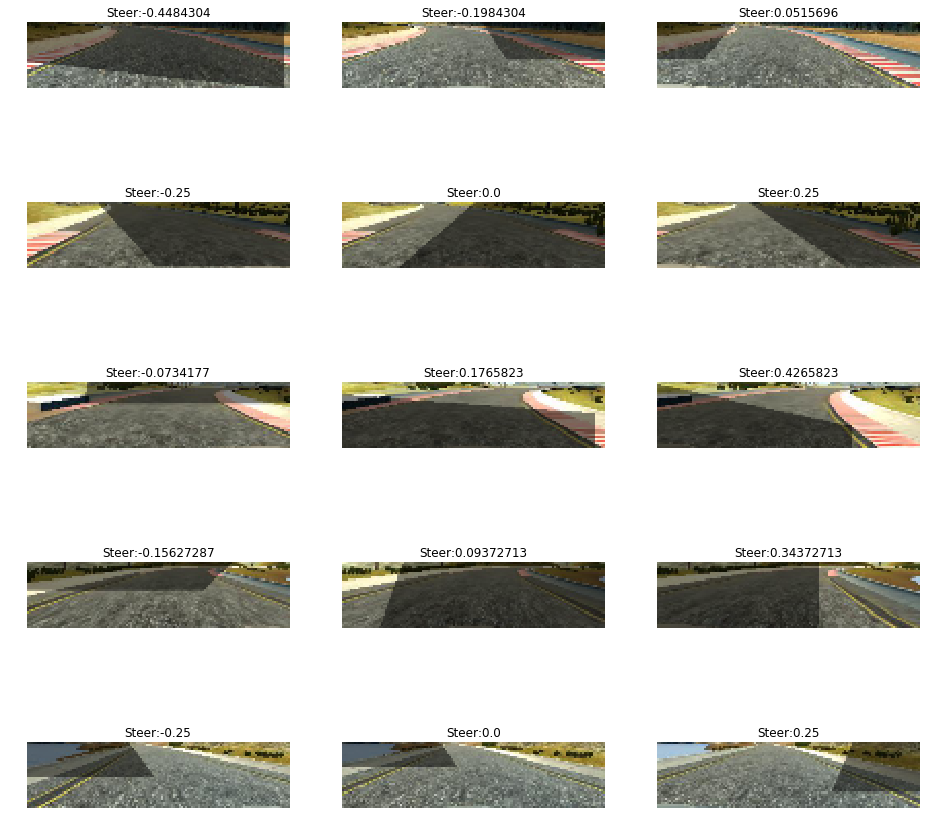

In [103]:
from skimage import transform
def cut_image(image, top_offset=.375, bottom_offset=.125):
    top = int(top_offset * image.shape[0])
    bottom = int(bottom_offset * image.shape[0])
    image1 = transform.resize(image[top:-bottom, :], (32, 128, 3))
    return image1

plt.figure(figsize=(16,16))
for i in range(len(images)):
    plt.subplot(5,3,i+1)
    plt.title('Steer:'+ str(steering[i]))
    plt.imshow(cut_image(simple_shadow(images[i])))
    plt.axis('off')

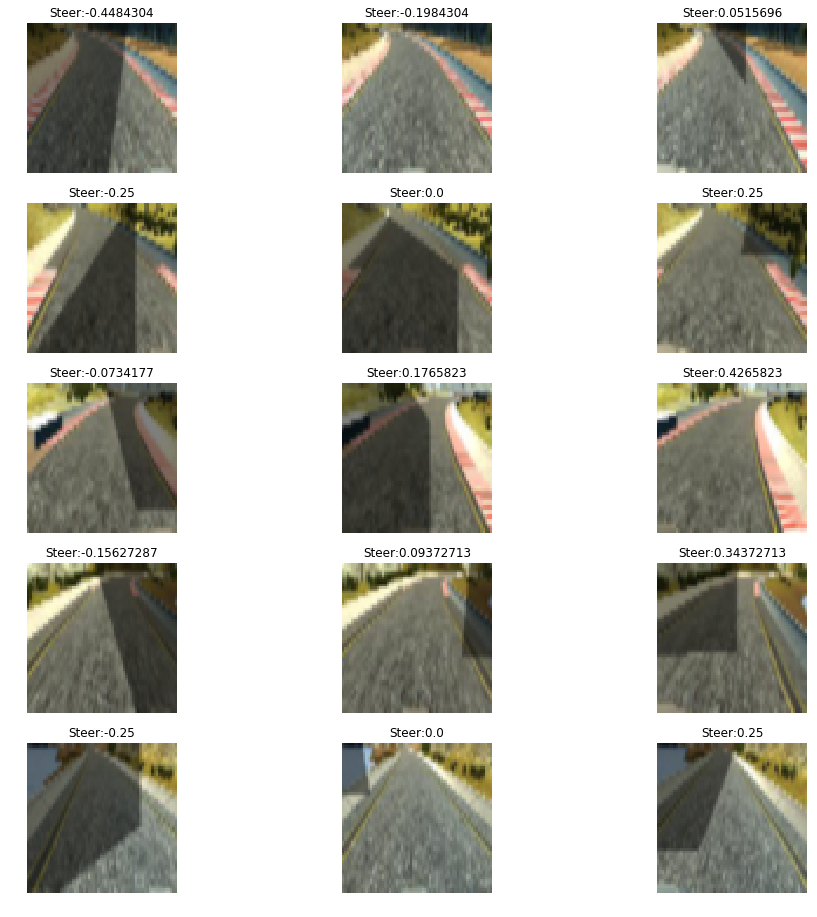

In [105]:
import scipy
def resize_image(image):
    image1 = scipy.misc.imresize(image, (64, 64))
    return image1

plt.figure(figsize=(16,16))
for i in range(len(images)):
    plt.subplot(5,3,i+1)
    plt.title('Steer:'+ str(steering[i]))
    plt.imshow(resize_image(cut_image(simple_shadow(images[i]))))
    plt.axis('off')